# Lecture 12 - Advanced Curve Fitting: Gaussian Process Regression

In [41]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Objectives

+ to do regression using a GP
+ to find the hyperparameters of the GP by maximizing the (marginal) likelihood
+ to use GP regression for uncertainty propagation

## Readings

+ Please read [this](http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2903.pdf) OR watch [this video lecture](http://videolectures.net/mlss03_rasmussen_gp/?q=MLSS).

+ [Chapter 3 from C.E. Rasmussen's textbook on Gaussian processes](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)

+ [Section 5.4 in GP for ML textbook](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf).

+ See slides for theory.

## Motivation: A fully Bayesian paradigm for curve fitting

Remember why we are doing this:

+ Let's say that you have to learn some function $f(\cdot)$ from some space $\mathcal{X}$ to $\mathbb{R}$ (this could either be a supervised learning problem (regression or classification) or even an unsupervised learning problem.

+ You sit down and you think about $f(\cdot)$. What do you know about it? How large do you expect it be? How small do you expect it be? Is it continuous? Is it differentiable? Is it periodic? How fast does it change as you change its inputs?

+ You create a probability measure on the space of functions in which $f(\cdot)$ lives which is compatible with everything you know about it. Abusing mathematical notation a lot, let's write this probability measure as $p(f(\cdot))$. Now you can sample from it. Any sample you take is compatible with your prior beliefs. You cannot tell which one is better than any other. Any of them could be the true $f(\cdot)$.

+ Then, you get a little bit of data, say $\mathcal{D}$. You model the likelihood of the data, $p(\mathcal{D}|f(\cdot))$, i.e., you model how the data may have been generated if you knew $f(\cdot)$.

+ Finally, you use Bayes' rule to come up with your posterior probability measure over the space of functions:
$$
p(f(\cdot)|\mathcal{D}) \propto p(\mathcal{D}|f(\cdot)) p(f(\cdot)),
$$
which is simultaneously compatible with your prior beliefs and the data.

In the last lecture, we formalized mathematically the prior $p(f(\cdot))$.
Today, we will mathematically formalize the posterior $p(f(\cdot)|\mathcal{D})$.

## Reminder: The prior $p(f(\cdot))$

In the previous lecture, we defined $p(f(\cdot))$ through the concept of a Gaussian process (GP), a generalization of a multivariate Gaussian distribution to
*infinite* dimensions.
We argued that it defines a probability measure on a function space.
We wrote:
$$
f(\cdot) \sim \mbox{GP}\left(m(\cdot), k(\cdot, \cdot) \right),
$$
where 
$m:\mathbb{R}^d \rightarrow \mathbb{R}$ is the *mean function* and 
$k:\mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ is the *covariance function*.

We also discuss in detail the meaning of these equations.
Namely that for any points $\mathbf{x}_{1:n}=(\mathbf{x}_1,\dots,\mathbf{x}_n)$, the joint probability density of the function values:
$$
\mathbf{f}_{1:n} =
\left(
f(\mathbf{x}_1),
\dots,
f(\mathbf{x}_n)
\right).
$$
is the multivariate Gaussian:
$$
\mathbf{f}_{1:n} | \mathbf{x}_{1:n} \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$
with mean vector:
$$
\mathbf{m}(\mathbf{x}_{1:n}) =
\left(
m(\mathbf{x}_1),
\dots,
m(\mathbf{x}_n)
\right),
$$
and covariance matrix:
$$
\mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) = \left(
\begin{array}{ccc}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{array}
\right).
$$
Please note that all the above expressions are conditional on the hyperparameters of the covariance function, e.g., lengthscales and signal variance for the squared exponential.
However, for now, we do not explicitly show this dependence.

## Gaussian process regression

Assume that the data we observe is:
$$
\mathcal{D} = (\mathbf{x}_{1:n}, y_{1:n}),
$$
where $y_i$ is not exactly $f(\mathbf{x}_i)$, but it may have some noise.
For the sake of simplicity, let's assume that the noise is Gaussian with variance $\sigma$ (you can relax this, but things will no longer be analytically available).
Assume that $\sigma$ is known (for now).
So, we have:
$$
y_i|f(\mathbf{x}_i) \sim \mathcal{N}(f(\mathbf{x}_i), \sigma^2),
$$
for a single observation.
For all the observations together, we can write:
$$
y_{1:n}| \mathbf{f}_{1:n} \sim \mathcal{N}(\mathbf{f}_{1:n}, \sigma^2\mathbf{I}_n),
$$
where $\mathbf{I}_n$ is the $n\times n$ unit matrix.

Let's draw a graphical model representation what we have here.
Remember that $\sigma$ and the hyperparameters of the covariance function, let's call them $\theta$, are (for the time being) fixed.

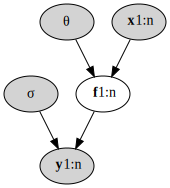

In [2]:
from graphviz import Digraph
g = Digraph('gp')
g.node('sigma', label='<&sigma;>', style='filled')
g.node('theta', label='<&theta;>', style='filled')
g.node('x1n', label='<<b>x</b><sub>1:n</sub>>', style='filled')
g.node('f', label='<<b>f</b><sub>1:n</sub>>')
g.node('y1n', label='<<b>y</b><sub>1:n</sub>>', style='filled')
g.edge('theta', 'f')
g.edge('x1n', 'f')
g.edge('f', 'y1n')
g.edge('sigma', 'y1n')
g

So, far so good, but how do we make predictions?
How do we get $p(f(\cdot)|\mathcal{D})$.
There are some nuances here.
We are looking for a posterior measure over a function space.
This is a strange beast.
The only way we can describe it is through the joint probability density of the function values at any arbitrary collection of **test** points.
So, let's take $n^*$ such test points:
$$
\mathbf{x}^*_{1:n^*} = \left(\mathbf{x}^*_1,\dots,\mathbf{x}^*_{n^*}\right).
$$
Imagine that these cover the input space as densely as we wish.
Consider the vector of function values at these test points:
$$
\mathbf{f}^*_{1:n^*} = \left(f(\mathbf{x}_1^*),\dots,f(\mathbf{x}^*_{n^*})\right).
$$
We will derive the posterior over these points, i.e., we will derive $p(\mathbf{f}^*|\mathcal{D})$.
And we will be happy with that.

From the definition of the GP, we can now write the joint probability density of $\mathbf{f}$ and $\mathbf{f}^*$.
It is just a multivariate Gaussian.
We have:
$$
p(\mathbf{f}_{1:n}, \mathbf{f}^*_{1:n^*} | \mathbf{x}_{1:n}, \mathbf{x}^*_{1:n^*}) = \mathcal{N}\left(
\left(
\begin{array}{c}
\mathbf{f}_{1:n}\\
\mathbf{f}^*_{1:n^*}
\end{array}
\right)\middle |
\left(
\begin{array}{c}
\mathbf{m}(\mathbf{x}_{1:n})\\
\mathbf{m}(\mathbf{x}^*_{1:n^*})
\end{array}
\right),
\left(
\begin{array}{cc}
\mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) & \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}^*_{1:n^*})\\
\mathbf{K}(\mathbf{x}^*_{1:n^*}, \mathbf{x}_{1:n}) & \mathbf{K}(\mathbf{x}^*_{1:n^*}, \mathbf{x}_{1:n^*})
\end{array}
\right)
\right),
$$
where the block matrix is just the covariance matrix of all inputs $\mathbf{x}_{1:n}$ (observed) and $\mathbf{x}^*_{1:n^*}$ (test).
Let's visualize the situation again.

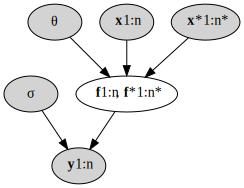

In [3]:
g2 = Digraph('gp2')
g2.node('sigma', label='<&sigma;>', style='filled')
g2.node('theta', label='<&theta;>', style='filled')
g2.node('x1n', label='<<b>x</b><sub>1:n</sub>>', style='filled')
g2.node('f', label='<<b>f</b><sub>1:n</sub>, <b>f</b>*<sub>1:n*</sub>>')
g2.node('y1n', label='<<b>y</b><sub>1:n</sub>>', style='filled')
g2.node('xs1ns', label='<<b>x</b>*<sub>1:n*</sub>>', style='filled')
g2.edge('theta', 'f')
g2.edge('x1n', 'f')
g2.edge('f', 'y1n')
g2.edge('xs1ns', 'f')
g2.edge('sigma', 'y1n')
g2

Ok, now we have only finite dimensional probability densities.
This is great. We know what to do next.
We will use the basic probability rules:
$$
\begin{array}{ccc}
p(\mathbf{f}^*_{1:n^*} | \mathbf{x}^*_{1:n^*}, \mathcal{D}) &=& p(\mathbf{f}^*_{1:n^*} | \mathbf{x}^*_{1:^*}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n})\\
&=& \int p(\mathbf{f}_{1:n}, \mathbf{f}^*_{1:n^*} | \mathbf{x}^*_{1:^*}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n})d\mathbf{f}_{1:n}\;\text{(sum rule)}\\
&\propto& \int p(\mathbf{y}_{1:n}| \mathbf{f}_{1:n}) p(\mathbf{f}_{1:n}, \mathbf{f}^*_{1:n^*}|\mathbf{x}^*_{1:^*}, \mathbf{x}_{1:n}) d\mathbf{f}_{1:n}\;\text{(Bayes' rule)}.
\end{array}
$$
This is the integral of a Gaussian times a Gaussian.
We are not going to go into the details, but you can actually do it analytically.
The result is... a Gaussian:
$$
p(\mathbf{f}^*_{1:n^*}| \mathbf{x}^*_{1:n^*}, \mathcal{D}) = \mathcal{N}\left(\mathbf{f}^*_{1:n^*}\middle| \mathbf{m}_n(\mathbf{x}^*_{1:n^*}), \mathbf{K}_n(\mathbf{x}^*_{1:n^*},\mathbf{x}^*_{1:n^*})\right),
$$
where *posterior mean function* is:
$$
m_n(x) = m(x) + \mathbf{k}(x,\mathbf{x}_{1:n})\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n})+\sigma^2I_n\right)^{-1}\left(\mathbf{y}_{1:n} - \mathbf{m}(\mathbf{x}_{1:n})\right),
$$
and the *posterior covariance function* is:
$$
k_n(x, x') = k(x,x') - \mathbf{k}(x,\mathbf{x}_{1:n})\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n})+\sigma^2I_n\right)^{-1}\mathbf{k}^T(x,\mathbf{x}_{1:n}),
$$
with
$$
\mathbf{k}(x,\mathbf{x}_{1:n}) = \left(k(x,\mathbf{x}_1),\dots,k(x,\mathbf{x}_n)\right)
$$
being the cross-covariance vector.

Now notice that the test points $\mathbf{x}^*_{1:n^*}$ are arbitrary and that the joint distribution of the function values at these points, $\mathbf{f}^*$, conditioned on the observations $\mathcal{D}$ is a multivariate Gaussian with a mean and covariance matrix specified by the posterior mean and covariance functions, respectively.
This is the defintion of a Gaussian process!
Therefore, we conclude that the posterior probability measure over the space of functions is also a Gaussian process:
$$
f(\cdot)|\mathcal{D} \sim \operatorname{GP}(m_n(\cdot), k_n(\cdot, \cdot)).
$$

### The point predictive distribution

What if you just want to make a prediction at a single point?
How do you do that?
Well, this is quite simple.
Your "test points" $\mathbf{x}^*_{1:n^*}$ are now just a single point, say $\mathbf{x}^*$.
Your prediction about the function value at this point is captured by:
$$
p\left(f(\mathbf{x}^*) | \mathcal{D}\right) = \mathcal{N}\left(f(\mathbf{x}^*)\middle|m_n(\mathbf{x}^*), \sigma_n^2(\mathbf{x}^*)\right),
$$
where the *predictive variance* is just:
$$
\sigma_n^2(\mathbf{x}^*) = k_n(\mathbf{x}^*,\mathbf{x}^*).
$$
This is what we will be using the most.

Now, if you wanted to predict $y^*$ at $\mathbf{x}^*$, i.e., the measurement at $\mathbf{x}^*$, you have do this:
$$
p(y^*|\mathbf{x}^*, \mathcal{D}) = \int p(y^*|f(\mathbf{x}^*)) p(f(\mathbf{x}^*)|\mathcal{D}) df(\mathbf{x}^*) = \mathcal{N}\left(f(\mathbf{x}^*)\middle|m_n(\mathbf{x}^*), \sigma_n^2(\mathbf{x}^*)+\sigma^2\right).
$$
Notice that you need to add the noise variance when you are talking about the measurement.

## Example: Gaussian process regression in 1D with fixed hyper-parameters

Let's generate some synthetic 1D data to work with:

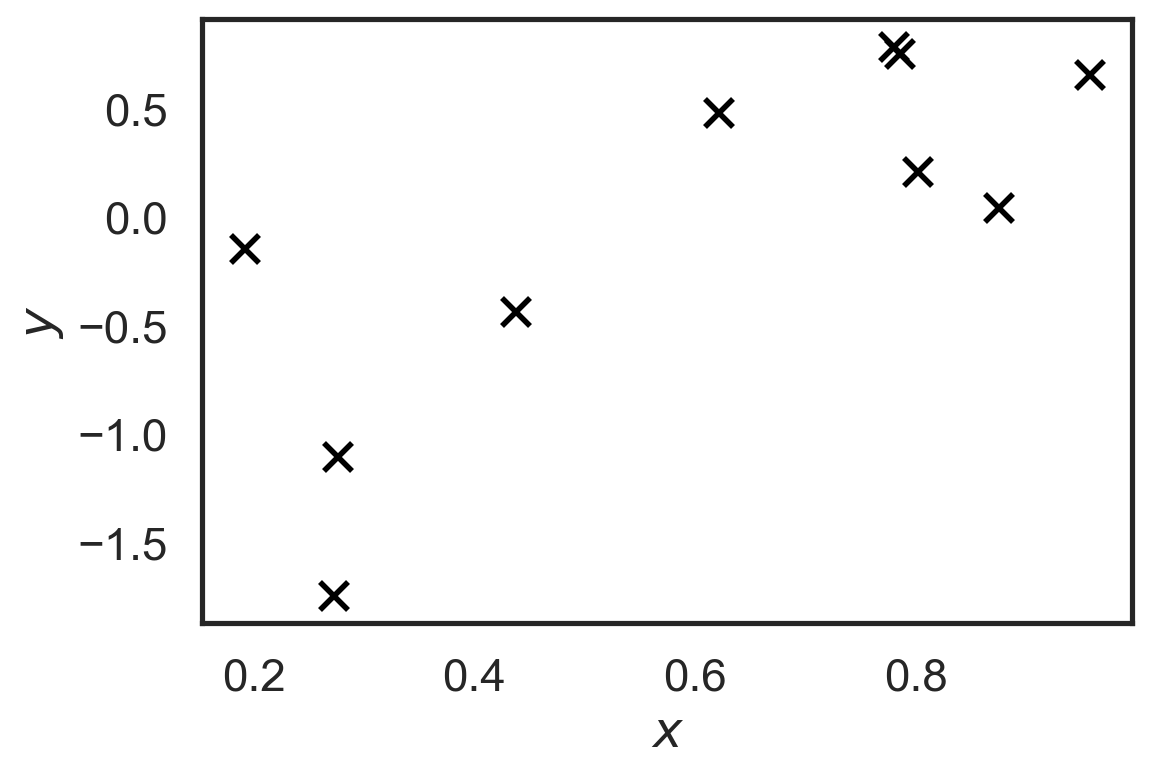

In [4]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 10
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The outputs are given from a function plus some noise
# The standard deviation of the noise is:
sigma = 0.4
# The true function that we will try to identify
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# Some data to train on
Y = f_true(X) + sigma * np.random.randn(X.shape[0], 1)
# Let's visualize the data
fig, ax = plt.subplots(dpi=200)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [5]:
# Now, we will get started with the regression
# First, import GPy
import GPy
# Second, pick a kernel. Let's pick a squared exponential (RBF = Radial Basis Function)
k = GPy.kern.RBF(1) # The parameter here is the dimension of the input (here 1)
# Let's print the kernel object to see what it includes:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


The ``variance`` of the kernel is one. This seems reasonable.
Let's leave it like that.
The ``lengthscale`` seems to big.
Let's change it to something reasonable (based on our expectations):

In [6]:
k.lengthscale = 0.1
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.1  |      +ve      |        


There is a possibility to choose a mean function, but for simplicity we are going to pick a zero mean function:
$$
m(x) = 0.
$$
Now we put together the GP regression model as follows:

In [8]:
gpm = GPy.models.GPRegression(X, Y, k) # It is input, output, kernel

This model is automatically assuming that the likelihood is Gaussian (you can modify it if you wish).
Where do can you find the $\sigma^2$ parameter specifying the likelihood noise? Here it is:

In [9]:
print(gpm)


Name : GP regression
Objective : 13.15046970174311
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


We will talk about the meaning of all that later. For now, let's just fix the noise variance to something reasonable (actually the correct value):

In [10]:
gpm.likelihood.variance = sigma ** 2
print(gpm)


Name : GP regression
Objective : 10.178171187043075
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |                  1.0  |      +ve      |        
  rbf.lengthscale          |                  0.1  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |      +ve      |        


That's it. We have now specified the model completely.
The posterior GP is completely defined.
Where is the posterior mean $m_n(x)$ and variance $\sigma_n^2(x)$? You can get them like this:

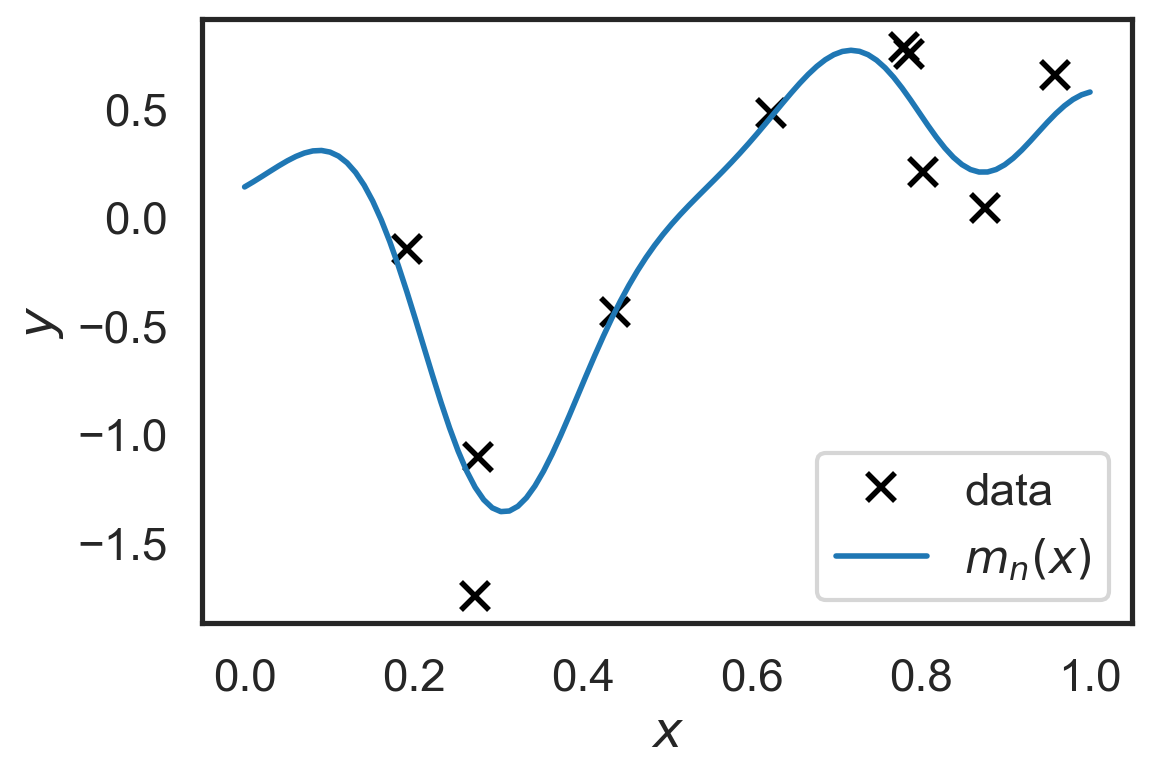

In [11]:
# First the mean on some test points
x_star = np.linspace(0, 1, 100)[:, None] # This is needed to turn the array into a column vector
m_star, v_star = gpm.predict(x_star)
# Let's plot the mean first
fig, ax = plt.subplots(dpi=200)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
plt.legend(loc='best');

Extracting the variance is a bit more involved.
Just a tiny bit though.
This is because ``v_star`` returned by ``gpm.predict`` is not exactly $\sigma_n^2(x)$.
It is actually $\sigma_n^2(x) + \sigma^2$ and not just $\sigma_n^2(x)$.
Here, see it:

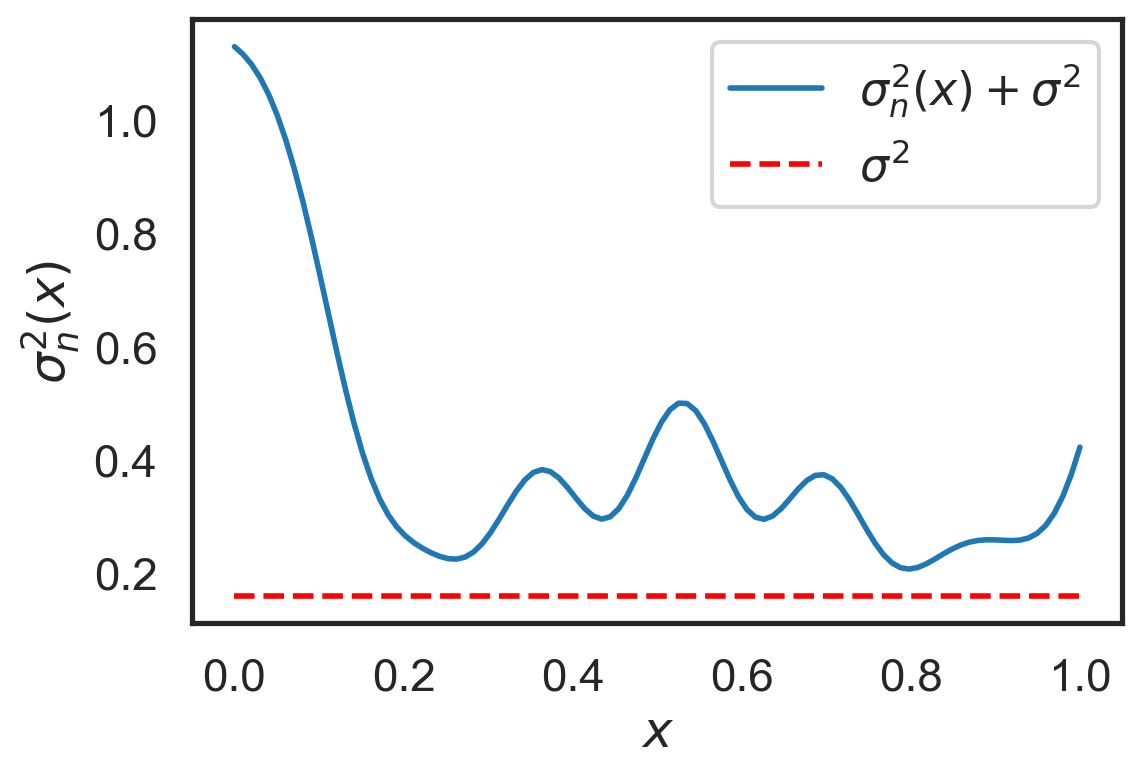

In [12]:
# Now the variance on the same test points
fig, ax = plt.subplots(dpi=200)
ax.plot(x_star, v_star, lw=2, label='$\sigma_n^2(x) + \sigma^2$')
ax.plot(x_star, gpm.likelihood.variance * np.ones(x_star.shape[0]), 'r--', lw=2, label='$\sigma^2$')
ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma_n^2(x)$')
plt.legend(loc='best');

Notice that the variance is small wherever we have an observation.
It is not, however, exactly, $\sigma^2$.
It will become exactly $\sigma^2$ in the limit of many observations.

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:
$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$
Let's plot this:

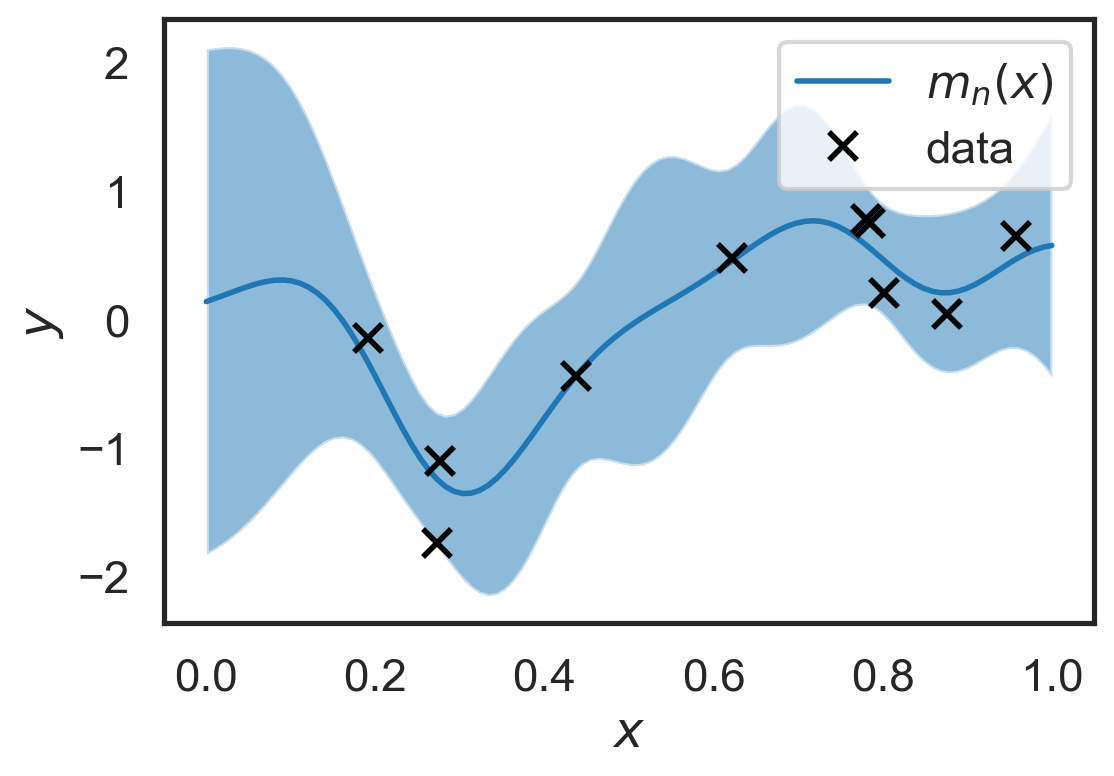

In [13]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5)
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
plt.legend(loc='best');

Now, on the same plot, let's superimpose our predictive error bar about $y^*$.
This is:
$$
m_n(\mathbf{x}^*)) - 2\sqrt{\sigma_n^2(\mathbf{x}^*)+\sigma^2}\le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sqrt{\sigma_n(\mathbf{x}^*) + \sigma^2}.
$$
Let's use red color for this:

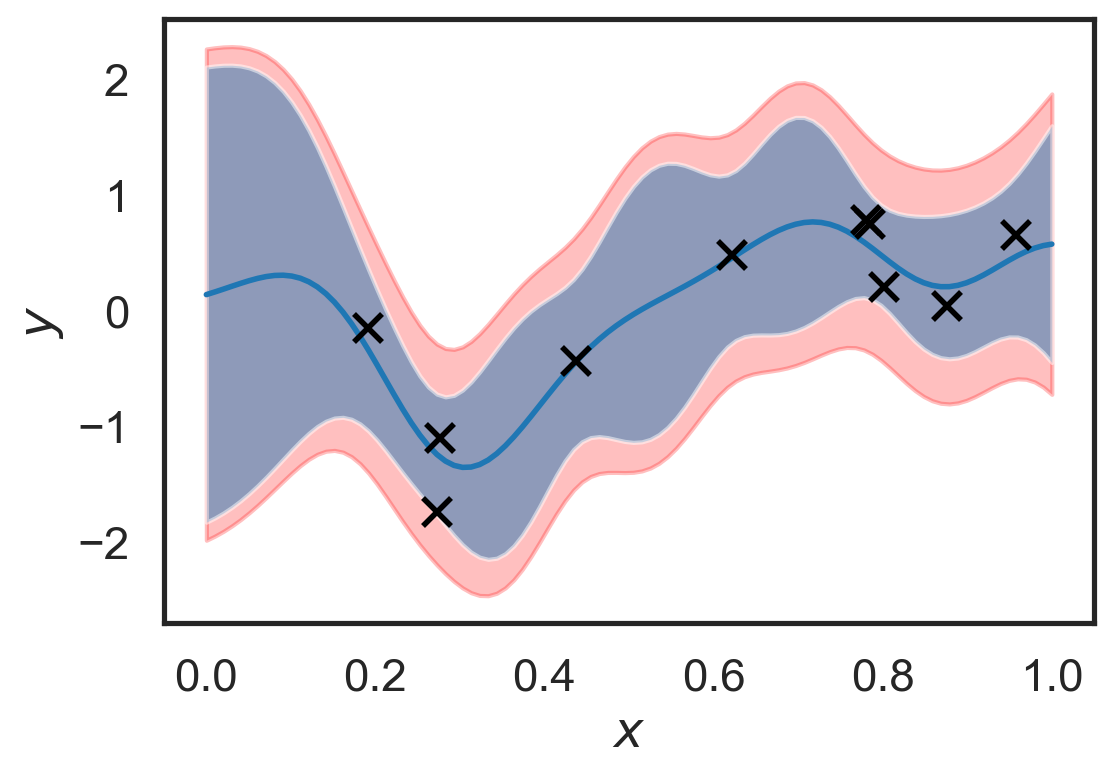

In [14]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
#plt.legend(loc='best');

Let's also put the correct function there for comparison:

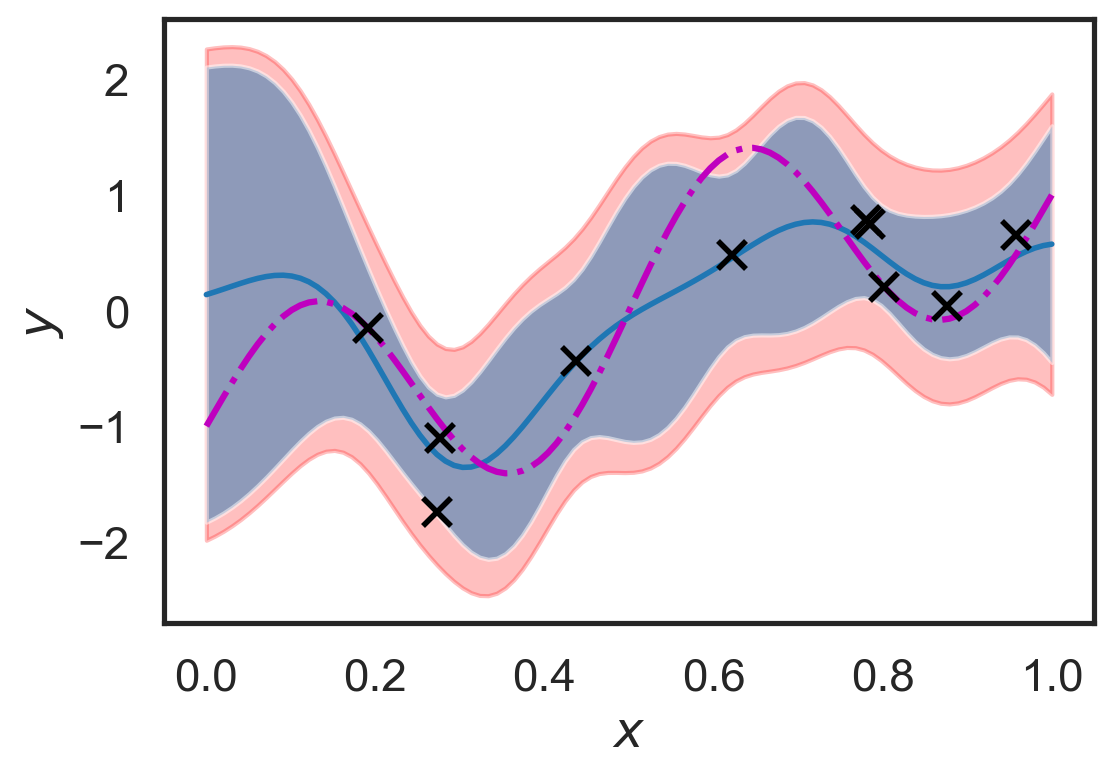

In [15]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
#plt.legend(loc='best');

You see that the true function is almost entirely within the blue bounds.
It is ok that it is a little bit off, becuase these are 95% prediction intervals.
About 5% of the function can be off.

That's good.
However, we have much more information encoded in the posterior GP.
It is actually a probability measure over the space of functions.
How do we sample functions?
Well, you can't sample functions...
They are infinite objects.
But you can sample the *function values* on a bunch of test points.
As a matter of fact, the joint probability density of the function values at any collection of set points is a multivariate Gaussian.
We did it manually in the last lecture.
In this lecture, we are going to use the capabilities of ``GPy``.
Here it is:

In [16]:
# Here is how you take the samples
f_post_samples = gpm.posterior_samples_f(x_star, 10) # Test points, how many samples you want
# Here is the size of f_post_samples
print(f_post_samples.shape)

(100, 1, 10)


This is ``test points x number of outputs (1 here) x number of samples``.
Let's plot them along with the data and the truth:

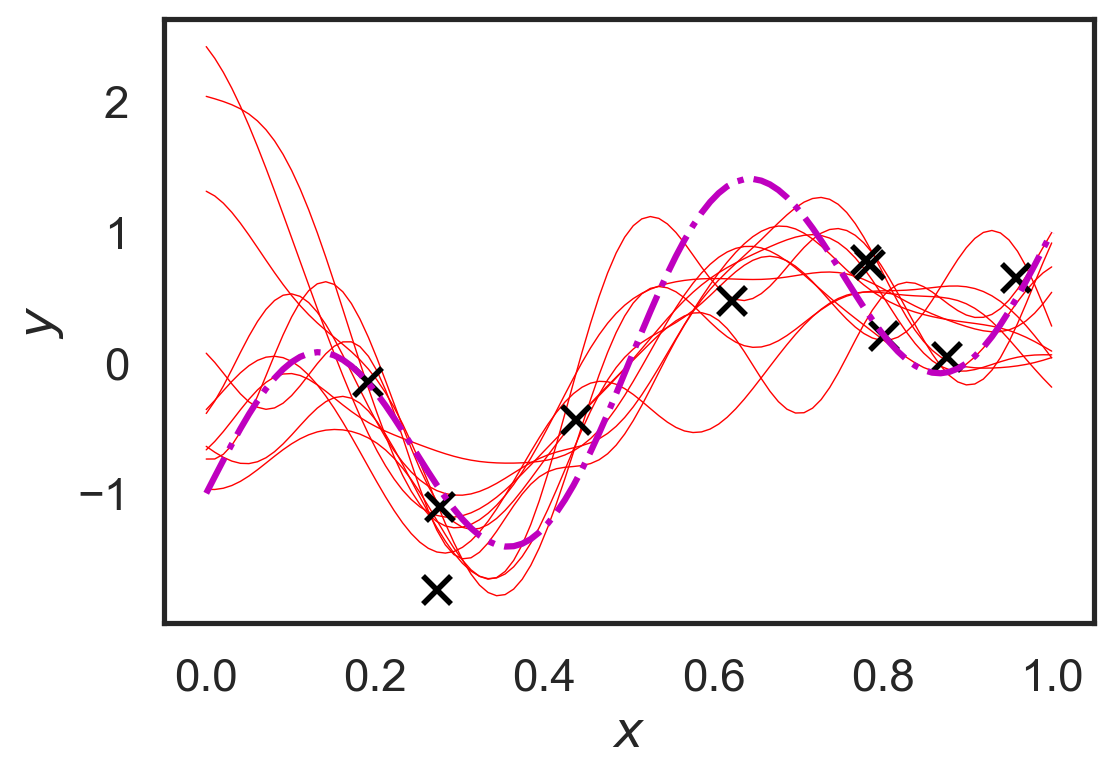

In [17]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Ok, we see that the lengthscale we have assumed does not match the lengthscale of the true function perfectly.
But that's how it is.
In real problems, you won't know the true function anyway. 

The following interactive function regenerates the figures above allowing you to experiment with various choices of the hyperparameters.

In [18]:
from ipywidgets import interact_manual

def analyze_and_plot_gp_ex1(kern_variance=1.0, kern_lengthscale=0.1, like_variance=0.4):
    """
    Performs GP regression with given kernel variance, lengthcale and likelihood variance.
    """
    #k = GPy.kern.RBF(1)
    k = GPy.kern.Matern32(1)
    gp_model = GPy.models.GPRegression(X, Y, k)
    # Set the parameters
    gp_model.kern.variance = kern_variance
    gp_model.kern.lengthscale = kern_lengthscale
    gp_model.likelihood.variance = like_variance
    # Print model for sanity check
    print(gp_model)
    # Pick test points
    x_star = np.linspace(0, 1, 100)[:, None]
    # Get posterior mean and variance
    m_star, v_star = gp_model.predict(x_star)
    # Plot 1: Mean and 95% predictive interval
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    f_lower = m_star - 2.0 * np.sqrt(v_star - gp_model.likelihood.variance)
    f_upper = m_star + 2.0 * np.sqrt(v_star - gp_model.likelihood.variance)
    y_lower = m_star - 2.0 * np.sqrt(v_star)
    y_upper = m_star + 2.0 * np.sqrt(v_star)
    ax1.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
    ax1.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
    ax1.plot(x_star, m_star, lw=2, label='$m_n(x)$')
    ax1.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax1.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
    #plt.legend(loc='best');
    
    # Plot 2: Data plus posterior samples
    fig2, ax2 = plt.subplots()
    f_post_samples = gp_model.posterior_samples_f(x_star, 10)
    ax2.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
    ax2.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
    ax2.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    #plt.legend(loc='best');
    
interact_manual(analyze_and_plot_gp_ex1,
            kern_variance=(0.01, 1.0, 0.01),
            kern_lengthscale=(0.01, 1.0, 0.01),
            like_variance=(0.01, 1.0, 0.01));

interactive(children=(FloatSlider(value=1.0, description='kern_variance', max=1.0, min=0.01, step=0.01), Float…

### Questions

In the interactive tool above:

+ Experiment with differnet lengthscales for the kernel. You need to click on ``Run Interact`` for the code to run.
What happens to the posterior mean and the 95% predictive error bar as the lengthscale increases (decreases)?

+ Experiment with difference likelihood variances. What happens for very big variances? What happens for very small variances?

+ Experiment with different kernel variances. This the $s^2$ parameter of the squared exponential covariance function. It specifies our prior variance about the function values. What is its effect?

+ Imagine that, as it would be the case in reality, you do not know the true function. How would you pick the correct values for the hyperparameters specifying the kernel?

+ Try some other kernels. Edit the function ``analyze_and_plot_gp_ex1`` and change the line ``k = GPy.kern.RBF(1)`` to ``k = GPy.kern.Matern52(1)``. This is a kernel that is less regular than the RBF. What do you observe?
Then try ``k = GPy.kern.Matern32(1)``. Then ``k = GPy.kern.Exponential(1)``. The last one is continuous but nowhere differentiable.
How can you pick the right kernel?

## Diagnostics: How do you know if the fit is good?

To objective test the resulting model we need a *validation dataset* consisting of inputs:
$$
\mathbf{x}^v_{1:n^v} = \left(\mathbf{x}^v_1,\dots,\mathbf{x}^v_{n^v}\right),
$$
and corresponding, observed outputs:
$$
\mathbf{y}^v_{1:n^v} = \left(y^v_1,\dots,y^v_{n^v}\right).
$$
We will use this validation dataset to define some diagnostics.
Let's do it directly through the 1D example above.
First, we generate some validation data:

In [36]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v) + sigma * np.random.randn(n_v, 1)

#### Point-predictions

Point-predictions only use $m_n\left(\mathbf{x}^v_i\right)$.
Of course, when there is a lot of noise, they are not very useful.
But let's look at what we get anyway.
(In the questions section I will ask you to reduce the noise and repeat).

The simplest thing we can do is to compare $y^v_i$ to $m_n\left(\mathbf{x}^v_i\right)$.
We start with the *mean square error*:
$$
\operatorname{MSE} := \frac{1}{n^v}\sum_{i=1}^{n^v}\left[y^v_i-m_n\left(\mathbf{x}^v_i\right)\right]^2.
$$

In [37]:
m_v, v_v = gpm.predict(X_v)
mse = np.mean((Y_v - m_v) ** 2)
print('MSE = {0:1.2f}'.format(mse))

MSE = 0.47


This is not very intuitive though.
An somewhat intuitive measure is [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) also known as $R^2$, *R squared*.
It is defined as:
$$
R^2 = 1 - \frac{\sum_{i=1}^{n^v}\left[y_i^v - m_n(\mathbf{x}_i^v)\right]^2}{\sum_{i=1}^{n^v}\left[y_i^v-\bar{y}^v\right]^2},
$$
where $\bar{y}^v$ is the mean of the observed data:
$$
\bar{y}^v = \frac{1}{n^v}\sum_{i=1}^{n^v}y_i^v.
$$
The interpretation of $R^2$, and take this with a grain of salt, is that it gives the percentage of variance of the data explained by the model.
A score of $R^2=1$, is a perfect fit.
In our data we get:

In [38]:
R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print('R2 = {0:1.2f}'.format(R2))

R2 = 0.42


Finally, on point-predictions, we can simply plot the predictions vs the observations:

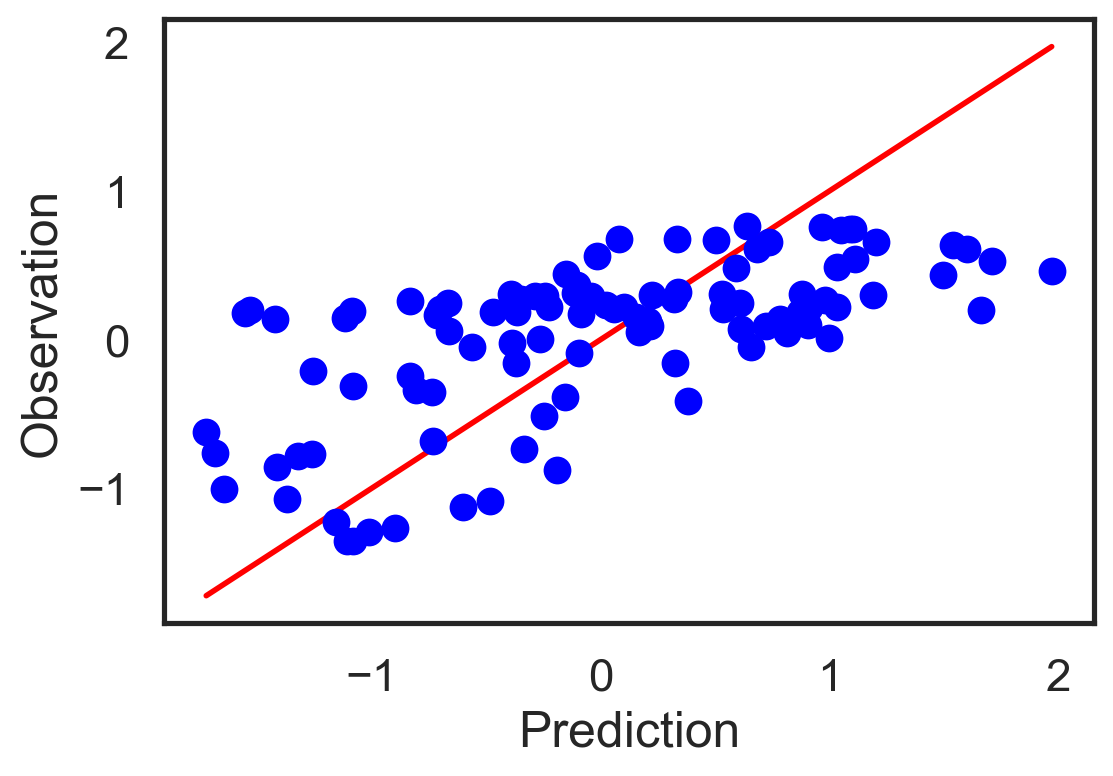

In [39]:
fig, ax = plt.subplots(dpi=200)
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v, m_v, 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation');

### Statistical diagnostics

Statistical diagnostics compare the predictive distribution to the distribution of the validation dataset.
The way to start, are the standarized errors defined by:
$$
e_i = \frac{y_i^v - m_n\left(\mathbf{x}^v_i\right)}{\sigma_n\left(\mathbf{x}^v_i\right)}.
$$
Now, if our model is correct, the standarized errors must be distributed as a standard normal $N(0,1)$ (why?).
There are various plots that you can do to test that.
First, the histogram of the standarized errors:

Text(0.5, 0, 'Std. error')

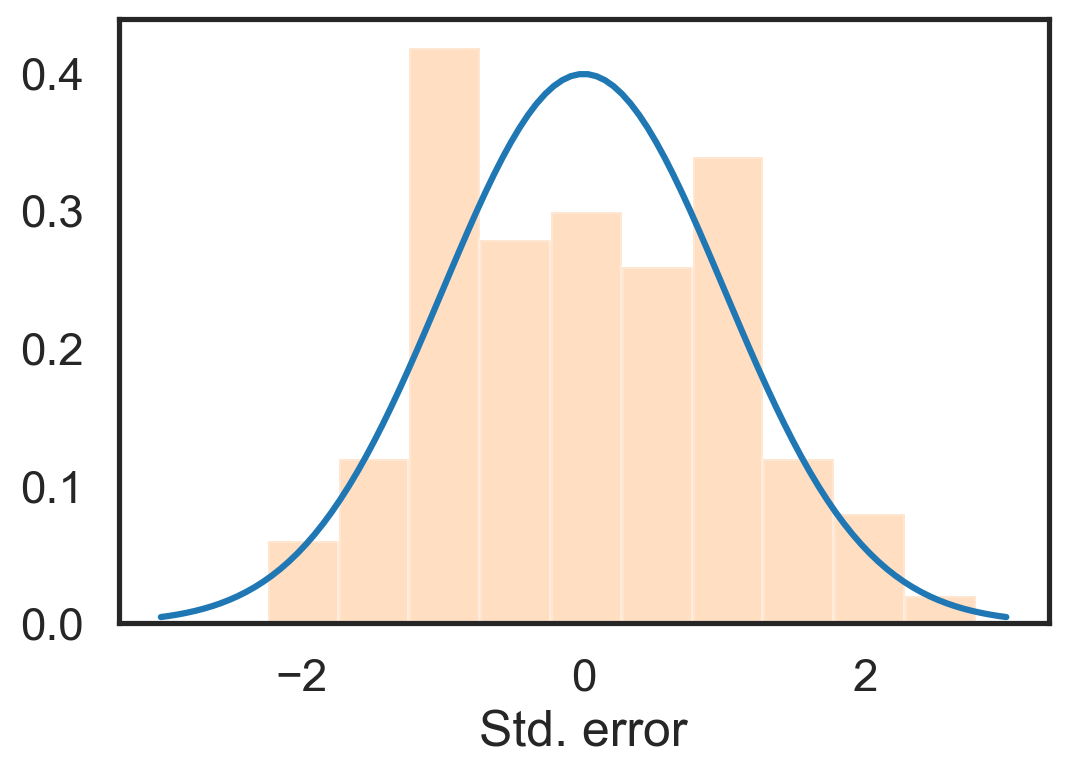

In [43]:
s_v = np.sqrt(v_v)
e = (Y_v - m_v) / s_v
fig, ax = plt.subplots(dpi=200)
zs = np.linspace(-3.0, 3.0, 100)
ax.plot(zs, st.norm.pdf(zs))
ax.hist(e, density=True, alpha=0.25)
ax.set_xlabel('Std. error')

Close, but not perfect.
Another common plot is this:

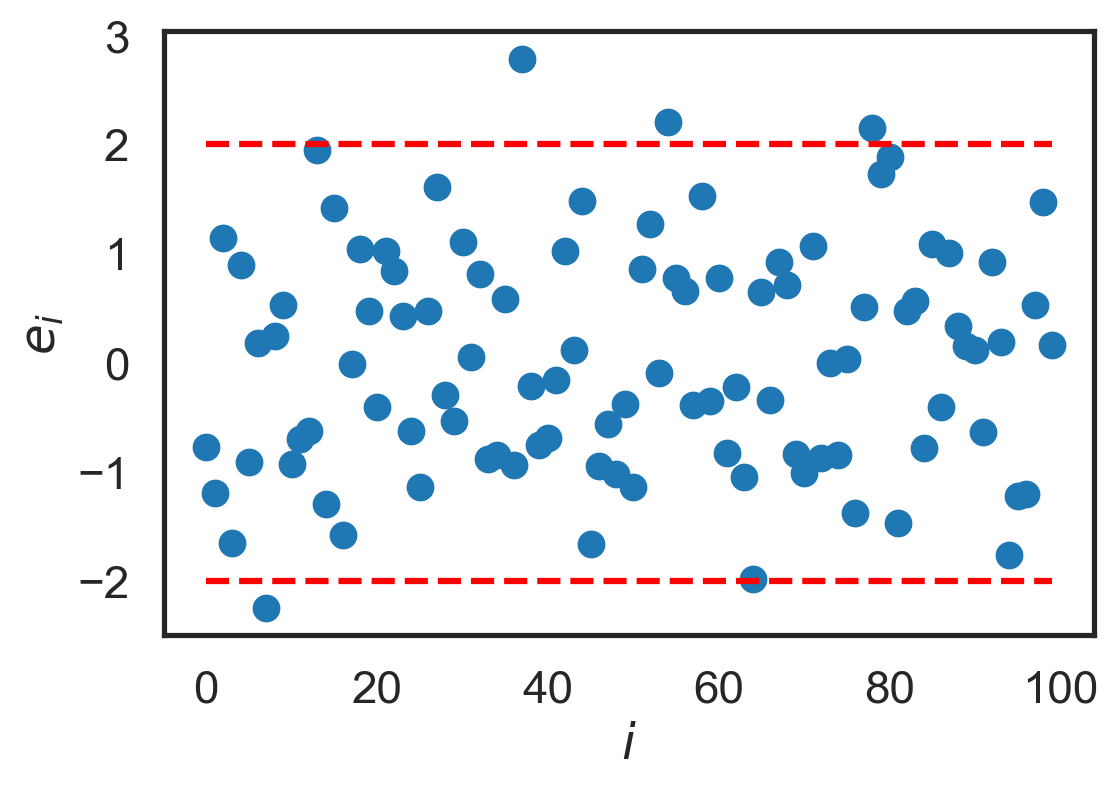

In [47]:
fig, ax = plt.subplots(dpi=200)
ax.plot(e, 'o')
ax.plot(np.arange(e.shape[0]), 2.0 * np.ones(e.shape[0]), 'r--')
ax.plot(np.arange(e.shape[0]), -2.0 * np.ones(e.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$e_i$');

Where the red lines indicate the 95% quantiles of the standard normal.
This  means that if 5\% of the errors are inside, then we are good to go.

Yet another plot yielding the same information is the q-q plot comparing the empirical quantiles of the standarized errors to what they are supposed to be, i.e., to the quantiles of $N(0,1)$:

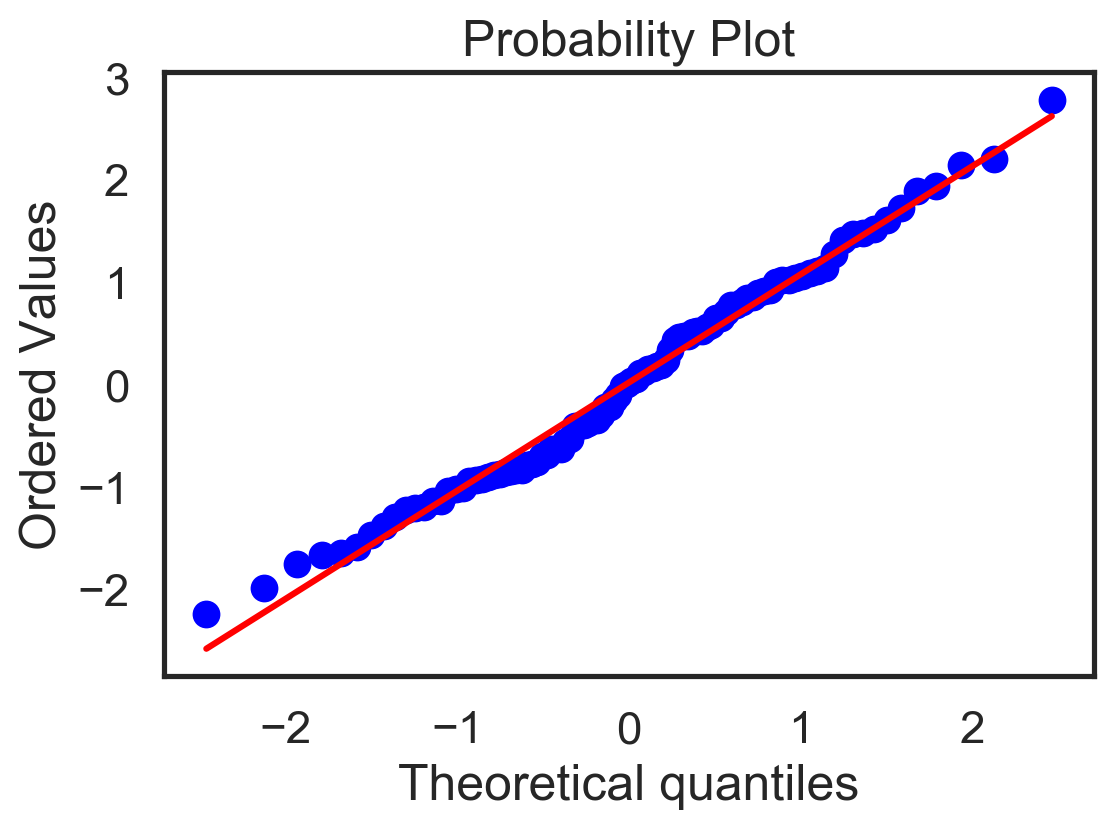

In [50]:
fig, ax = plt.subplots(dpi=200)
st.probplot(e.flatten(), dist=st.norm, plot=ax);

### On statistics, p-values, and statistical significance

...

## Calibrating the Hyperparameters of a Gaussian Process

So, we saw how GP regression works but everything we did was conditional on knowing the hyperparameters of the covariance function, we called them $\theta$, and the likelihood variance $\sigma^2$.
But if what do we do if we are not sure about them?
We will do what we always do:

+ We summarize our state of knowledge about them by assigning prior probability density $p(\theta)$ and $p(\sigma)$.

+ We use the Bayes rule to derive our posterior state of knowledge about them:
$$
\begin{array}{ccc}
p(\theta,\sigma | \mathcal{D}) &\propto& p(\mathcal{D}|\theta,\sigma)p(\theta)p(\sigma) \\
&=& \int p(\mathbf{y}_{1:n}|\mathbf{f}_{1:n},\sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n},\theta)d\mathbf{f}_{1:n} p(\theta)p(\sigma).
\end{array}
$$

+ We somehow approximate this posterior. So far, we only know of one way of approximating this posterior, and that is by a maximum a posteriori estimate.

### Making a little bit of analytical progress in the posterior
We stated without proof that the posterior of the hyperparameters is:
$$
p(\theta,\sigma|\mathcal{D}) \propto \int p(\mathbf{y}_{1:n}|\mathbf{f}_{1:n},\sigma)p(\mathbf{x}_{1:n},\theta)d\mathbf{f}_{1:n}p(\theta)p(\sigma).
$$
You should ry to familiriaze yourself with these expressions.
How can you just see the validity of these expressions?
It's quite simple if you look at the graph.
So, let's draw the graph.

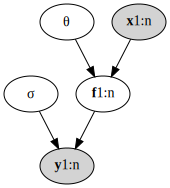

In [24]:
g3 = Digraph('gp')
g3.node('sigma', label='<&sigma;>')
g3.node('theta', label='<&theta;>')
g3.node('x1n', label='<<b>x</b><sub>1:n</sub>>', style='filled')
g3.node('f', label='<<b>f</b><sub>1:n</sub>>')
g3.node('y1n', label='<<b>y</b><sub>1:n</sub>>', style='filled')
g3.edge('theta', 'f')
g3.edge('x1n', 'f')
g3.edge('f', 'y1n')
g3.edge('sigma', 'y1n')
g3

The graph, tells you how the joint distribution of all the variables decomposes in conditional probabilities.
You know that the parent nodes condition the children nodes.
Here is the decomposition here:
$$
p(\mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \mathbf{f}_{1:n}, \theta, \sigma) =
p(\mathbf{y}_{1:n} | \mathbf{f}_{1:n}, \sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \theta)p(\theta)p(\sigma)p(\mathbf{x}_{1:n}).
$$
Now, by Bayes' rule, we know that the conditional joint probability density of all unobserved variables is proportional to the joint:
$$
p(\theta, \sigma, \mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \mathbf{f}_{1:n}, \theta, \sigma).
$$
The normalization constant does not matter, i.e., we can drop $p(\mathbf{x}_{1:n})$, so we get:
$$
p(\theta, \sigma, \mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{y}_{1:n} | \mathbf{f}_{1:n}, \sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \theta)p(\theta)p(\sigma).
$$
Finally, to get the posterior over $\theta$ and $\sigma$ only, we *marginalize* (i.e., integrate out) the unobserved variable $\mathbf{f}_{1:n}$.
Here, the integral is actually analytically available (integral of a Gaussian times a Gaussian which is a Gaussian).
If you do the math, you will get:
$$
p(\theta,\sigma | \mathcal{D}) \propto \mathcal{N}\left(\mathbf{y}_{1:n}\middle|
\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right) p(\theta)p(\sigma).
$$

### Maximum a Posteriori Estimate of the Hyperparameters

In the maximum a posteriori estimate (MAP) we are basically approximating the posterior with the $\delta$-function centered at its pick.
That is, we are approximating:
$$
p(\theta,\sigma|\mathcal{D}) \approx \delta(\theta-\theta^*)\delta(\sigma-\sigma^*),
$$
where $\theta^*$ and $\sigma^*$ are maximizing $\log p(\theta,\sigma|\mathcal{D})$.
It is instructive to see what $\log p(\theta,\sigma|\mathcal{D})$ looks like and see if we can assign any intuitive meaning to its terms.
It is:
$$
\begin{array}{ccc}
\log p(\theta,\sigma|\mathcal{D}) &=& \log \mathcal{N}\left(\mathbf{y}_{1:n}\middle|
\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right) + \log p(\theta) + \log p(\sigma) \\
&=& 
-\frac{1}{2}\left(\mathbf{y}_{1:n}-\mathbf{m}(\mathbf{x}_{1:n})\right)^T\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right)^{-1}\left(\mathbf{y}_{1:n}-\mathbf{m}(\mathbf{x}_{1:n})\right)\\
&&-\frac{1}{2}\log |\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n|\\
&&+\log p(\theta) + \log p(\sigma)\\
&& + \text{constants}.
\end{array}
$$
The constants are terms that do not depend on $\theta$ or $\sigma$.
The first term is a familiar one.
It kind of looks like least squares (it is actually a form of least squares).
The third and forth term are familiar regularizers stemming from our prior knowledge.
The second term is a naturally occuring regularizer.

Now, back to solving the optimization problem that yields the MAP.
Of course, you need to get the deratives of $\log p(\theta,\sigma|\mathcal{D})$ and use an optimization algorithm.
Back in the stone age, we were doing this by hand.
Now you don't have to worry about it.
Automatic differentiation can work through the entire expression (including the matrix determinant).
Once you have the derivative you can use a gradient-based optimization algorithm from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).
``GPy`` is using by default the [L-BFGS algorithm](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) but you could change it if you want.
These are minimization algorithms.
So, ``GPy`` is actually minimizing $-\log p(\theta,\sigma)$.
Let's see how it works through our previous example:

## Example: Gaussian process regression with fitted hyperparameters

Make sure that you still have the data from the previous example:

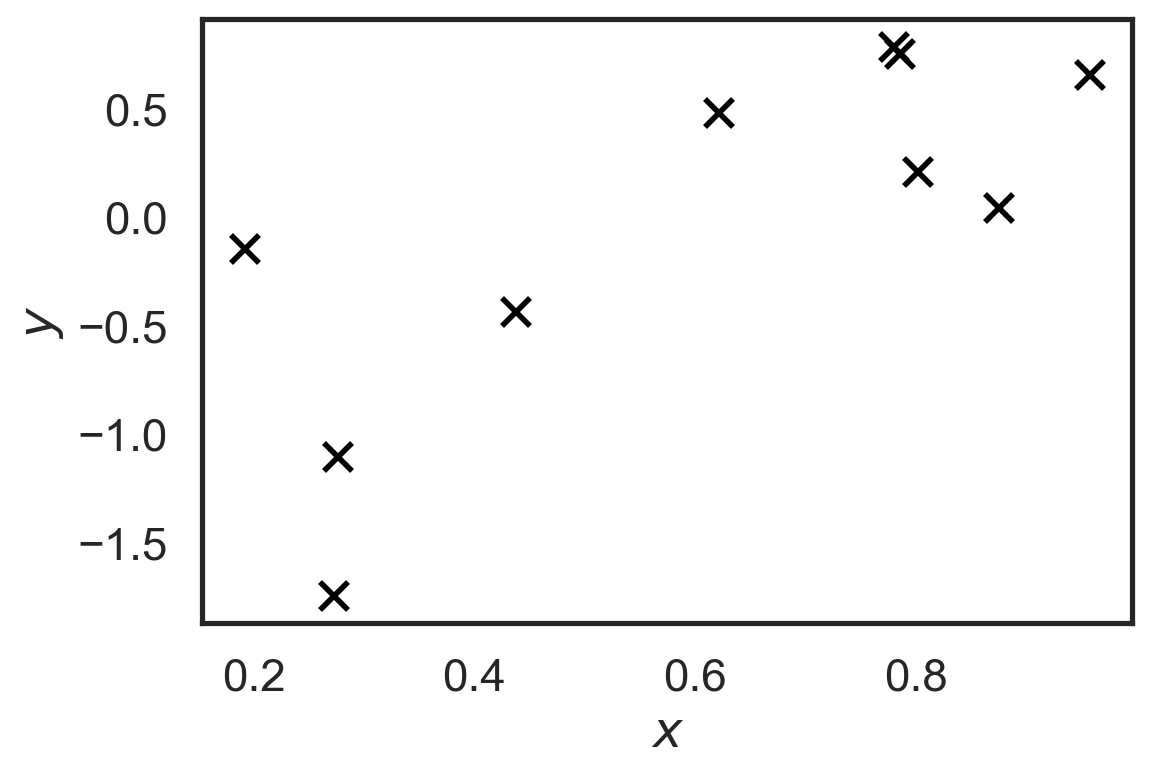

In [61]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 10
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The outputs are given from a function plus some noise
# The standard deviation of the noise is:
sigma = 0.4
# The true function that we will try to identify
# Some data to train on
Y = f_true(X) + sigma * np.random.randn(X.shape[0], 1)
fig, ax = plt.subplots(dpi=200)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's pick a squared exponential kernel and make a model with Gaussian likelihood (the default choice):

In [72]:
k = GPy.kern.RBF(1) # GPy.kern.RBF(60, ARD=True)
gpm = GPy.models.GPRegression(X, Y, k)
print(gpm)


Name : GP regression
Objective : 13.029643687983668
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Let's explain what all this means.
Notice that there are some default values for the hyperparameters (they are all one).
Also, notice that ``GPy`` is keeping track of how many parameters it needs to fit.
Here we have three parameters ($s,\ell$ and $\sigma$).
The second column are constraints for the parameters.
The ``+ve`` term means that the corresponding hyperparamer has to be positive.
Notice that there is nothing in the ``priors`` column.
This is because we have set no priors right now.
When this happens, ``GPy`` assumes that we assign a flat prior, i.e., here it assumes that we have assigned $p(\theta)\propto 1$ and $p(\sigma)\propto 1$.
That's not the best choice, but it should be ok for now.

Now, pay attention to the ``Objective``. This is the $-\log p(\theta,\sigma|\mathcal{D})$ for the current choice of parameters.
Let's now find the MAP:

In [63]:
gpm.optimize_restarts(messages=True) # we use multiple restarts to avoid being trapped to a local minimum
print(gpm)


Name : GP regression
Objective : 9.376317801621127
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.4296554984401684  |      +ve      |        
  rbf.lengthscale          |  0.023487942263585283  |      +ve      |        
  Gaussian_noise.variance  |   0.07952049967422607  |      +ve      |        


Ok. We did find something with higher posterior value.
Let's plot the prediction:

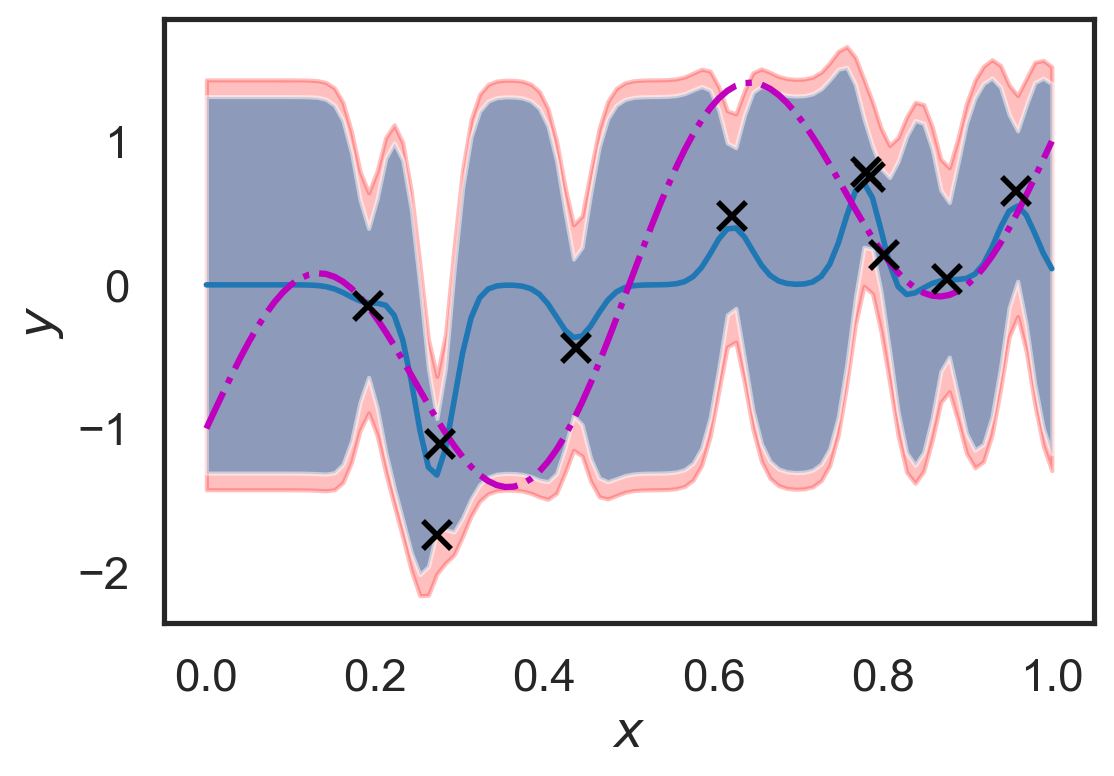

In [64]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

Admitidly, this doesn't look very good.
(Of course, we can tell this only because we know the truth).
It seems that the assign lengthscale is too small.
Also, the likelihood variance seems smaller than it really is.
What do we do now?
You have two choices:
+ You encode some prior knowledge and repeat.
+ You add some more data and repeat.

Let's start with some prior knowledge and let the other item for the questions section.
Let's say that we know that the noise variance.
How do we encode this?
Here you go:

In [73]:
gpm.likelihood.variance.constrain_fixed(sigma ** 2)
print(gpm)


Name : GP regression
Objective : 13.142900653688129
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |                  1.0  |      +ve      |        
  rbf.lengthscale          |                  1.0  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |        


Notice that it now ``GPy`` reports that the likelihood variance is fixed.
Let's repeat the optimization:

In [66]:
gpm.optimize_restarts(messages=True) # we use multiple restarts to avoid being trapped to a local minimum
print(gpm)

Optimization restart 1/10, f = 9.574736850990455


Optimization restart 2/10, f = 9.574736852047614


Optimization restart 3/10, f = 9.574736851154368


Optimization restart 4/10, f = 9.574736850995219


Optimization restart 5/10, f = 9.574736850990337


Optimization restart 6/10, f = 9.574736850990345


Optimization restart 7/10, f = 9.574736851048634


Optimization restart 8/10, f = 9.574736850992338


Optimization restart 9/10, f = 9.574736850995727


Optimization restart 10/10, f = 9.574736851022497

Name : GP regression
Objective : 9.574736850990337
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |     0.40792380306004  |      +ve      |        
  rbf.lengthscale          |  0.05041723300991304  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |        


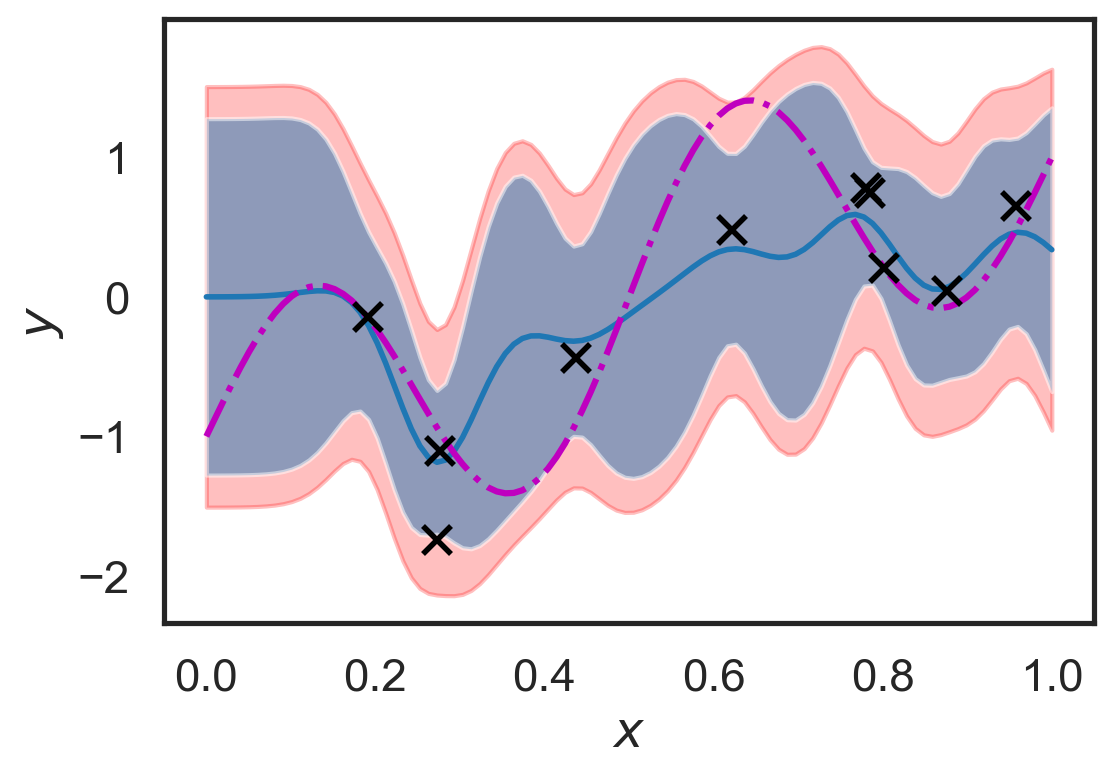

In [67]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

This looks better.
But it seems that the automatically selected lengthscale is smaller than the true one.
(Of course don't really know the true lengthscale is).
Let's assign a prior probability density on the lengthscale which pushes it to be greater.
Since we are dealing with a positie parameter and we don't know much about it, let's assign an exponential prior with a rate of 2 (which will yield an expectation of 0.5):
$$
\ell \sim \operatorname{Log-N}(0.2, 1).
$$

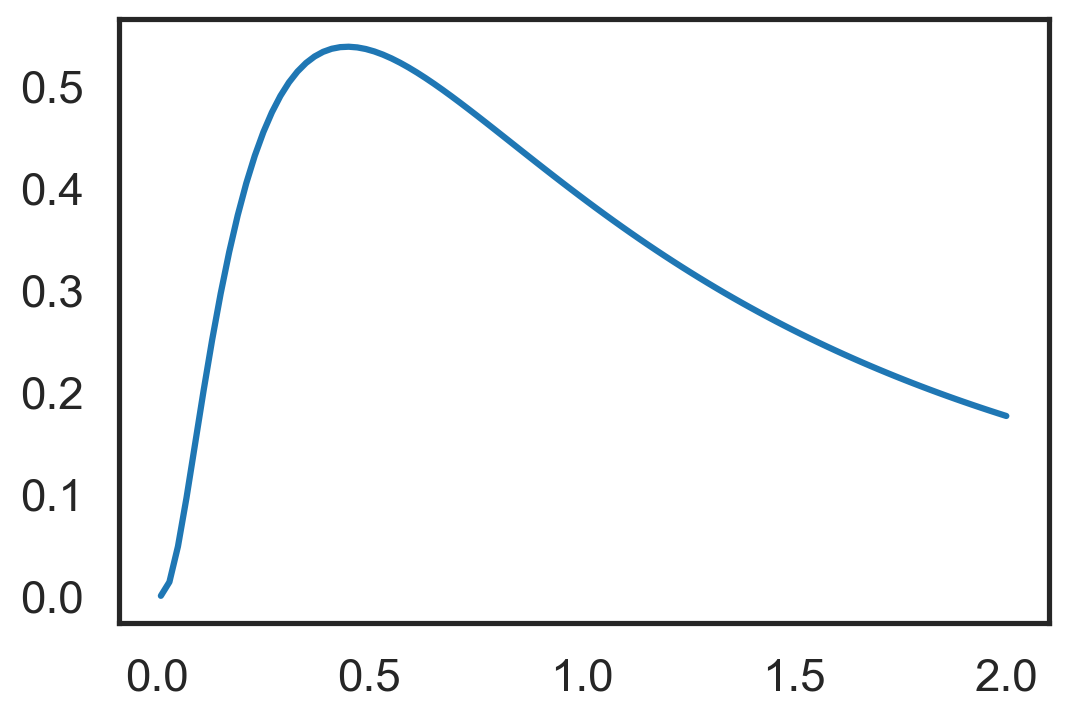

In [121]:
ell_prior = GPy.priors.LogGaussian(.2, 1.0)
# Let's visualize it to make sure it's ok
fig, ax = plt.subplots(dpi=200)
ells = np.linspace(0.01, 2.0, 100)
ax.plot(ells, ell_prior.pdf(ells))

Now here is how you can set it:

In [122]:
gpm.kern.lengthscale.set_prior(ell_prior)
print(gpm)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale



Name : GP regression
Objective : 12.772893807992885
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors   
  rbf.variance             |  0.48079481739688806  |      +ve      |             
  rbf.lengthscale          |   0.2585026668021247  |      +ve      |  lnN(0.2, 1)
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |             


In [123]:
gpm.optimize_restarts(messages=True)
print(gpm)

Optimization restart 1/10, f = 12.755925770647227


Optimization restart 2/10, f = 12.755925770647494


Optimization restart 3/10, f = 12.755925770663833


Optimization restart 4/10, f = 12.755925770652635


Optimization restart 5/10, f = 12.75592577064717


Optimization restart 6/10, f = 12.755925770647263


Optimization restart 7/10, f = 12.755925770657269


Optimization restart 8/10, f = 12.755925770647488


Optimization restart 9/10, f = 12.755925770650048


Optimization restart 10/10, f = 12.755925770671743

Name : GP regression
Objective : 12.75592577064717
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors   
  rbf.variance             |  0.46913607853718914  |      +ve      |             
  rbf.lengthscale          |   0.2319911337409182  |      +ve      |  lnN(0.2, 1)
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |             


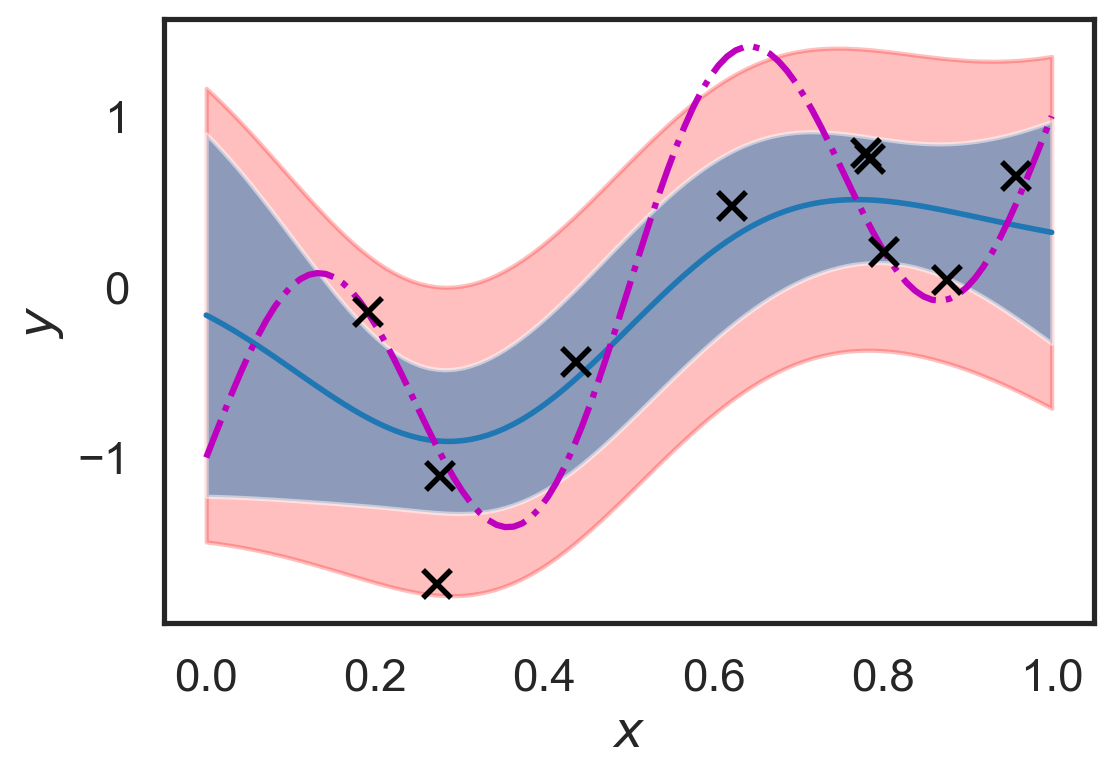

In [124]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

That's better, but not perfect.
But remember: You don't know what the truth is...

## Questions

Let's investigate what happens to the previous examples as you increase the number of observations.

+ Rerun everything gradually increasing the number of samples from $n=10$ to $n=100$.
Notice that as the number of samples increases it doesn't really matter what your prior knowledge is.
As a matter of fact, for the largest number of samples you try, pick a very wrong prior probability for $\ell$.
See what happens.

+ Rerun everything with $\sigma=0.01$ (small noise) and gradually increasing the number of samples from $n=10$ to $n=100$.
For small noise, the model is trying to interpolate.
Is it capable of figuring out that the noise is small when the number of observations is limited? When does the method realize the noise is indeed small?